# Chapter 6. Using a neural network to fit the data

## Imports

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from collections import OrderedDict

## Data

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # turn datapoints into many batches, each with 1 feature
t_u = torch.tensor(t_u).unsqueeze(1)

print(t_c.shape, t_u.shape)

# split into train/validation
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

# normalize data
t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

torch.Size([11, 1]) torch.Size([11, 1])


In [3]:
linear_model = nn.Linear(1, 1) # input, output, bias (default True)
linear_model(t_un_val)

tensor([[1.0188],
        [1.2254]], grad_fn=<AddmmBackward0>)

In [4]:
print(linear_model.weight)

Parameter containing:
tensor([[0.1033]], requires_grad=True)


In [5]:
print(linear_model.bias)

Parameter containing:
tensor([0.5187], requires_grad=True)


## Batching inputs

In [6]:
x = torch.ones(10, 1)
print(linear_model(x))

tensor([[0.6221],
        [0.6221],
        [0.6221],
        [0.6221],
        [0.6221],
        [0.6221],
        [0.6221],
        [0.6221],
        [0.6221],
        [0.6221]], grad_fn=<AddmmBackward0>)


In [7]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

print(list(linear_model.parameters()))

[Parameter containing:
tensor([[0.2808]], requires_grad=True), Parameter containing:
tensor([0.4282], requires_grad=True)]


In [8]:
def training_loop(n_epochs,
                  optimizer,
                  model,
                  loss_fn,
                  t_u_train,
                  t_u_val,
                  t_c_train,
                  t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # pass in the model, instead of parameters
        loss_train = loss_fn(t_p_train, t_c_train)
        
        with torch.no_grad():
            t_p_val = model(t_u_val)
            loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [9]:
# use torch.nn for the loss function
training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 135.1693, Validation loss 182.8026
Epoch 1000, Training loss 3.0605, Validation loss 7.5599
Epoch 2000, Training loss 2.4504, Validation loss 5.7236
Epoch 3000, Training loss 2.4376, Validation loss 5.4845

Parameter containing:
tensor([[5.2243]], requires_grad=True)
Parameter containing:
tensor([-16.4570], requires_grad=True)


## Neural networks

In [10]:
seq_model = nn.Sequential(
                nn.Linear(1, 13),
                nn.Tanh(),
                nn.Linear(13, 1)
            )
print(seq_model)

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)


In [12]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [14]:
seq_model = nn.Sequential(OrderedDict([
    ("hidden_linear", nn.Linear(1, 8)),
    ("hidden_activation", nn.Tanh()),
    ("output_linear", nn.Linear(8, 1))
]))

print(seq_model)

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)


In [15]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [16]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)

print("output", seq_model(t_un_val))
print("answer", t_c_val)
print("hidden", seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 164.0676, Validation loss 222.0617
Epoch 1000, Training loss 5.6413, Validation loss 5.8622
Epoch 2000, Training loss 3.7771, Validation loss 3.6988
Epoch 3000, Training loss 2.1127, Validation loss 1.8008
Epoch 4000, Training loss 1.9443, Validation loss 1.9044
Epoch 5000, Training loss 1.8977, Validation loss 1.9743
output tensor([[ 7.8941],
        [20.3991]], grad_fn=<AddmmBackward0>)
answer tensor([[ 6.],
        [21.]])
hidden tensor([[ 0.0019],
        [-0.0049],
        [ 0.0005],
        [ 0.0007],
        [-0.0019],
        [ 0.0011],
        [ 0.0064],
        [-0.0010]])


### Comparing to linear model

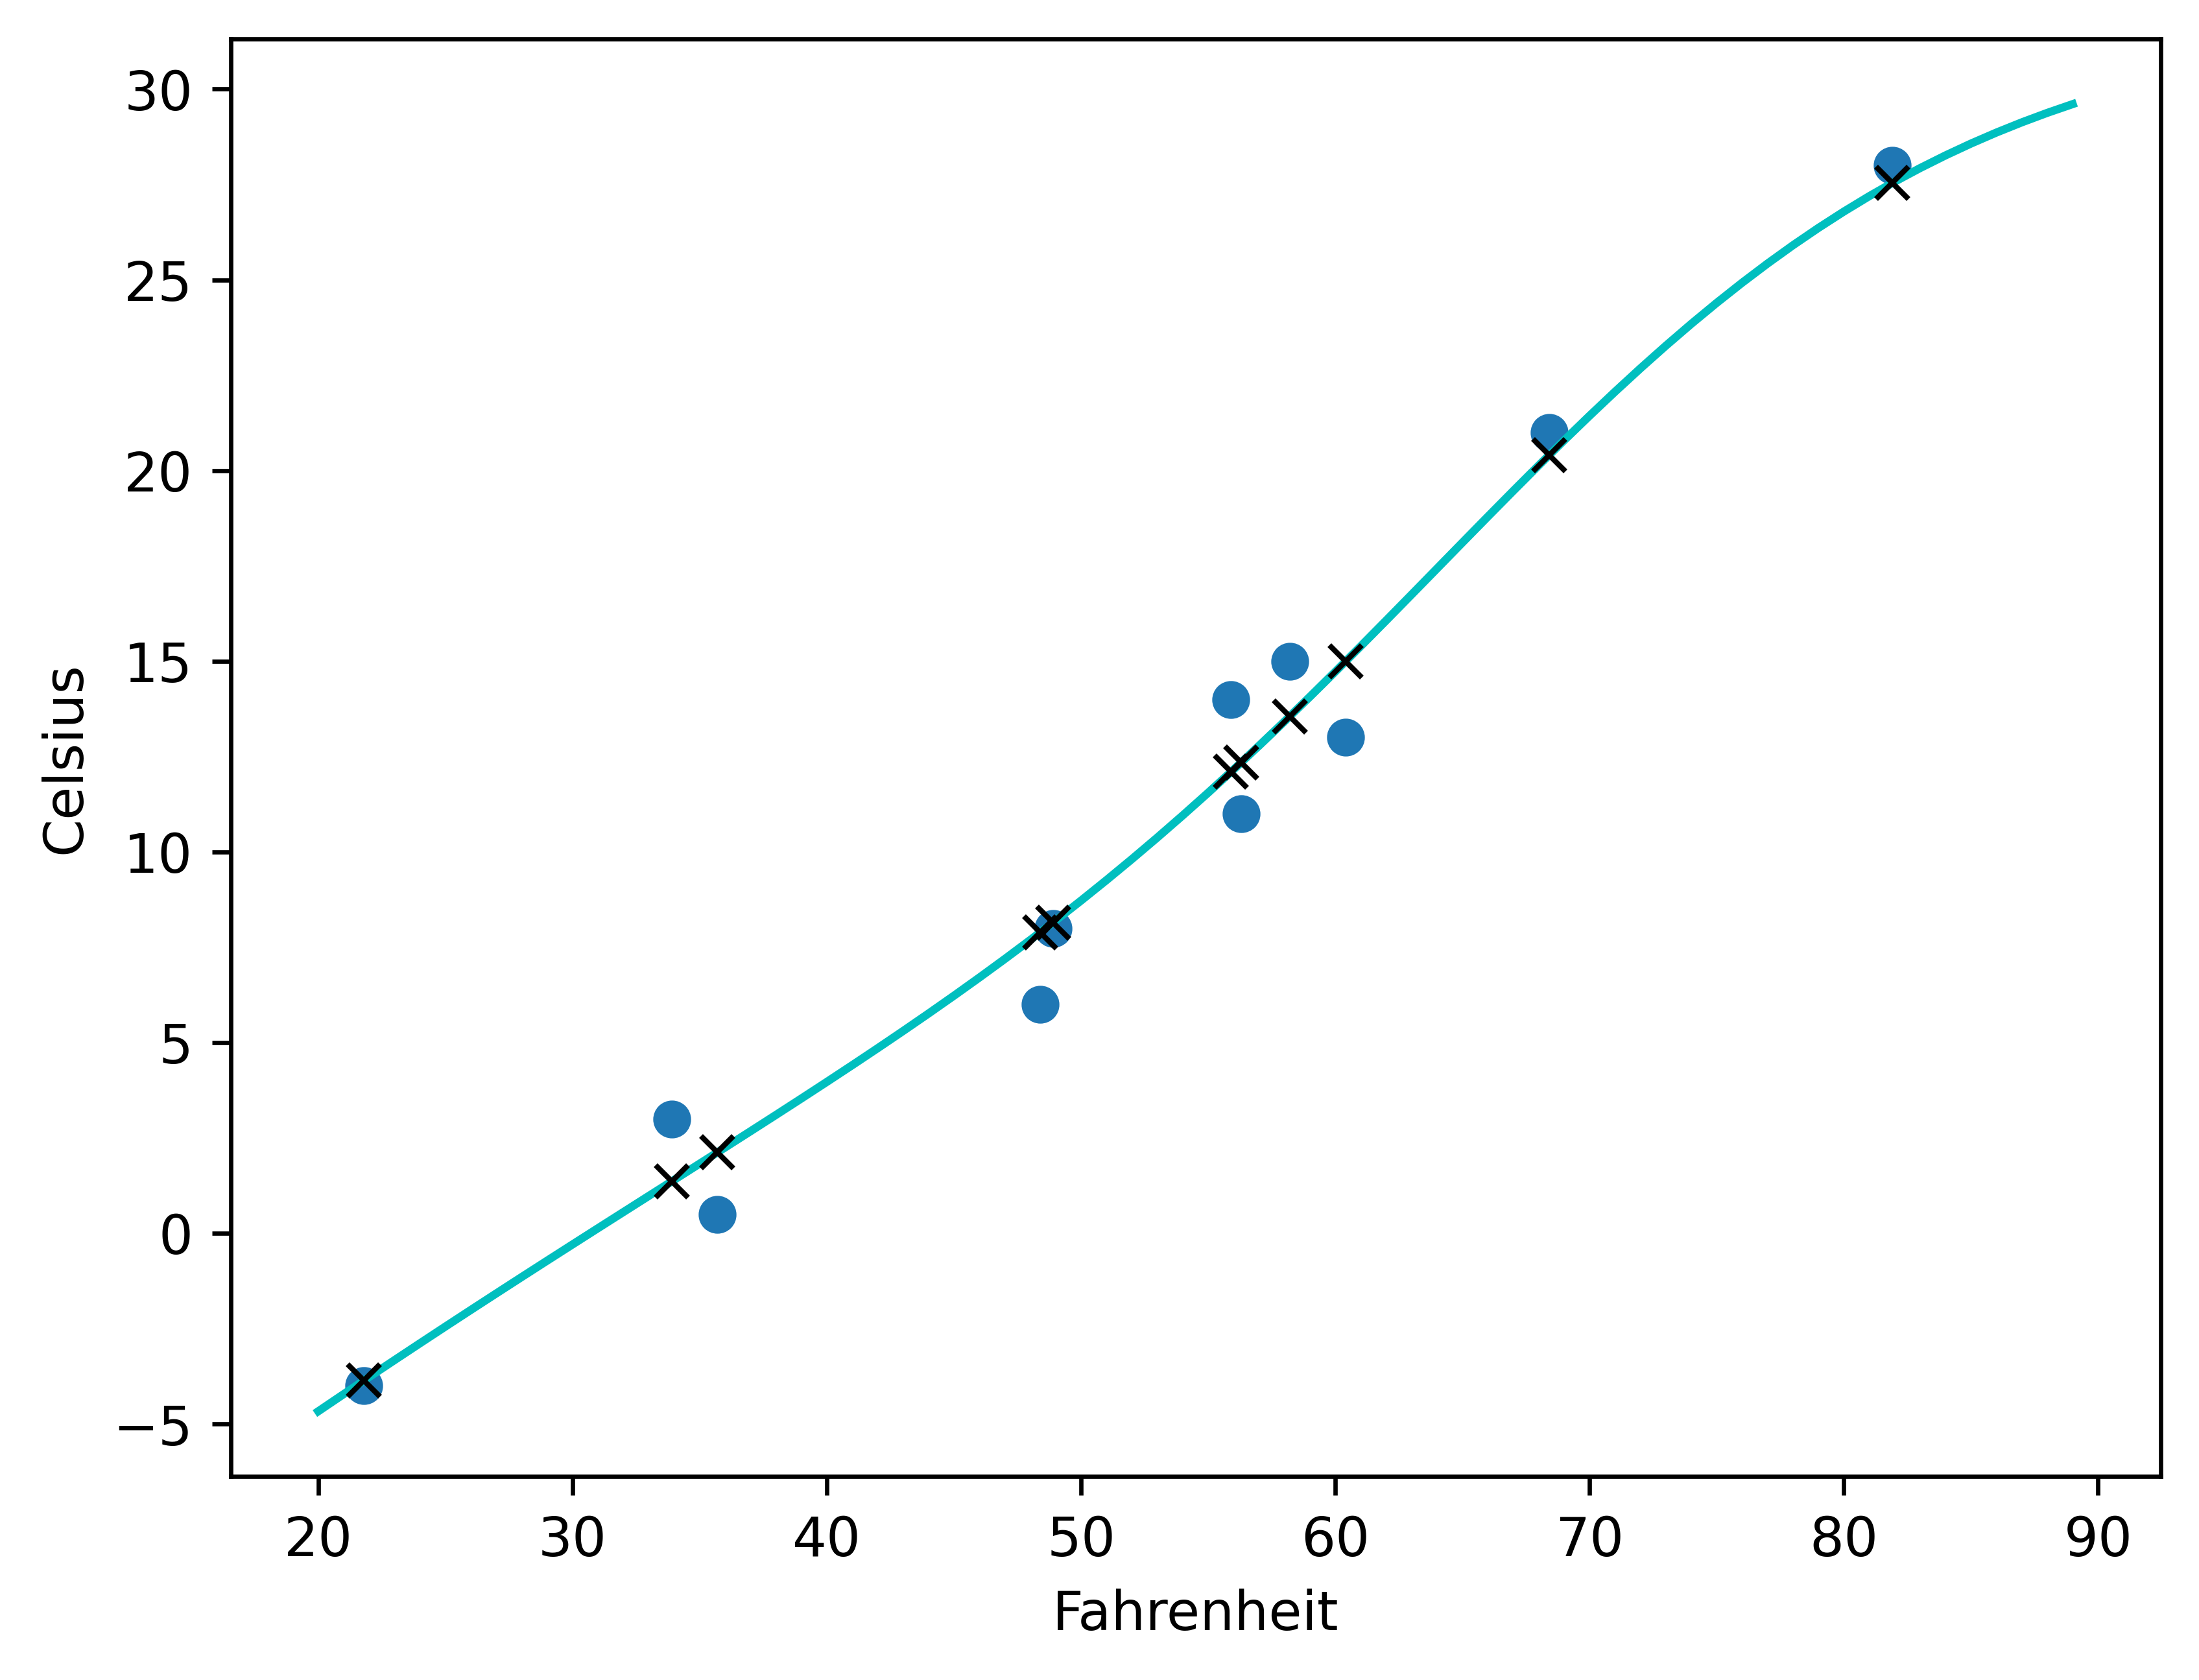

In [18]:
t_range = torch.arange(20., 90.).unsqueeze(1) # batch

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), "c-")
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), "kx")